In [1]:
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
tensorflow.keras.utils.set_random_seed(812)

2025-10-16 23:01:32.932975: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 23:01:32.974150: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 23:01:33.668713: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_augmentation = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,   
    height_shift_range=0.1 )
train_gen = train_augmentation.flow_from_directory(
        "/home/ocelot/Desktop/CNN_RPS/Archive/train",
        target_size=(100,150),
        batch_size=32,
        class_mode="sparse",
        color_mode="grayscale",
        seed=42

)

val_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    "/home/ocelot/Desktop/CNN_RPS/Archive/validation",
     target_size=(100,150),
     batch_size=32,
     class_mode="sparse",
     color_mode="grayscale",
     seed=42)

    

Found 1531 images belonging to 3 classes.
Found 438 images belonging to 3 classes.


0.0


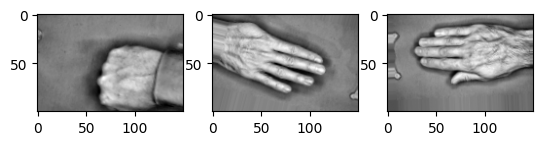

In [3]:
train_gen.batch_size = 3
fig, ax =  plt.subplots(1,3)
immagini = next(train_gen)
print(immagini[1][1])
for n,i in enumerate(immagini[0]):
    ax[n].imshow(i, cmap='gray')
train_gen.batch_size=32

In [4]:
 print(np.array([0.0, 0.0, 1.0]))


[0. 0. 1.]


In [5]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
def crea_modello(drop_param = 0.5, learning_rate=0.001, num_filter_1=32, num_filter_2=64):
    model = tensorflow.keras.models.Sequential([
        layer.InputLayer(shape=(100,150,1)),
        layer.Conv2D(filters=(num_filter_1), kernel_size=(3,3), activation="relu"),
        layer.MaxPooling2D(pool_size=(2,2)),
        layer.Conv2D(filters=(num_filter_2), kernel_size=(3,3), activation="relu"),
        layer.MaxPooling2D(pool_size=(2,2)),
        layer.Flatten(),
        layer.Dense(128, activation="relu"),
        layer.Dropout(drop_param),
        layer.Dense(3, activation="softmax")
    ])
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model
    

In [6]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
model = KerasClassifier(model = crea_modello, epochs=15, batch_size=32,verbose=0)
griglia = {
    "model__drop_param": [0.25, 0.5],
    "model__learning_rate":[1e-3, 5e-4, 1e-4],
    "model__num_filter_1":[32,64],
    "model__num_filter_2":[32,64]
}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=griglia,
    cv=kfold,               
    scoring='accuracy',         
    verbose=0,
    n_jobs=1 )

In [7]:
import os
import cv2
Im = []
target = []

cat = ["paper", "scissors", "rock"]
vettori = {"paper":0, "scissors":2, "rock":1}
for i in cat:
    for j in os.listdir(os.path.join("/home/ocelot/Desktop/CNN_RPS/Archive/train", i)):
        Im.append(cv2.imread(os.path.join("/home/ocelot/Desktop/CNN_RPS/Archive/train", i,j), 0))
        target.append(vettori[i])
X_train = np.array(Im).astype('float32') / 255.0
X_train = np.expand_dims(X_train, axis=-1)
Y_train = np.array(target)

In [8]:
%%time
risultati = grid_search.fit(X_train, Y_train )

I0000 00:00:1760648506.124567   29525 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13447 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-10-16 23:01:47.128066: I external/local_xla/xla/service/service.cc:163] XLA service 0x75605800d070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-16 23:01:47.128088: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-10-16 23:01:47.145272: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-16 23:01:47.241282: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-16 23:01:47.293455: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:2

CPU times: user 4min 46s, sys: 22.3 s, total: 5min 8s
Wall time: 7min 3s


In [9]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'model__drop_param': 0.5, 'model__learning_rate': 0.0005, 'model__num_filter_1': 32, 'model__num_filter_2': 64}


In [10]:
final_model = crea_modello(drop_param=0.5, learning_rate=0.0005, num_filter_1=32, num_filter_2=64)
history= final_model.fit(train_gen, epochs=50, callbacks=[early_stop], validation_data=val_gen)

Epoch 1/50


/home/ocelot/env/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.4030 - loss: 1.1350 - val_accuracy: 0.5068 - val_loss: 0.9976
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5683 - loss: 0.9426 - val_accuracy: 0.7329 - val_loss: 0.7300
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7165 - loss: 0.6738 - val_accuracy: 0.7671 - val_loss: 0.5650
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7956 - loss: 0.5422 - val_accuracy: 0.9452 - val_loss: 0.3029
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8276 - loss: 0.4684 - val_accuracy: 0.9361 - val_loss: 0.2682
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8576 - loss: 0.4004 - val_accuracy: 0.8744 - val_loss: 0.3499
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9073 - loss: 0.3052 - val_accuracy: 0.9384 - val_loss: 0.2006
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9099 - loss: 0.2790 - val_accuracy: 0.9658 - val_loss: 0.

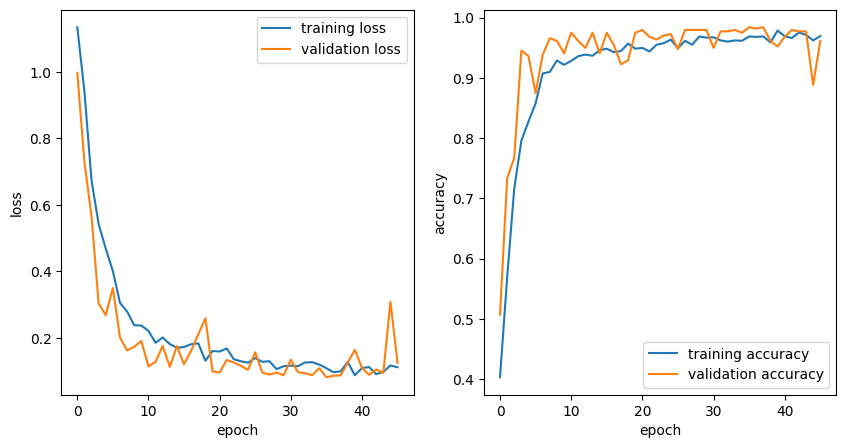

In [11]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
ax[0].plot(history.history["loss"], label="training loss")
ax[0].plot(history.history["val_loss"], label="validation loss")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(history.history["accuracy"], label="training accuracy")
ax[1].plot(history.history["val_accuracy"], label="validation accuracy")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()

In [16]:
test_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    "/home/ocelot/Desktop/CNN_RPS/Archive/test",
     target_size=(100,150),
     batch_size=32,
     class_mode="sparse",
     color_mode="grayscale",
     shuffle=False,
     seed=42)

Found 219 images belonging to 3 classes.


In [20]:
testLoss, testAccuracy = final_model.evaluate(test_gen)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9954 - loss: 0.0347 


In [22]:
import numpy as np
from sklearn.metrics import classification_report
pred = final_model.predict(test_gen)
pred = np.argmax(pred, axis=1)
real_label = test_gen.classes
keys = test_gen.class_indices.keys()
keys = list(keys)
report = classification_report(real_label, pred, target_names=keys, output_dict=True)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [23]:
report["scissors"]

{'precision': 0.9868421052631579,
 'recall': 1.0,
 'f1-score': 0.9933774834437086,
 'support': 75.0}

In [24]:
report["rock"]

{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 73.0}

In [25]:
report["paper"]

{'precision': 1.0,
 'recall': 0.9859154929577465,
 'f1-score': 0.9929078014184397,
 'support': 71.0}

Label predetta: scissors Label vera: paper


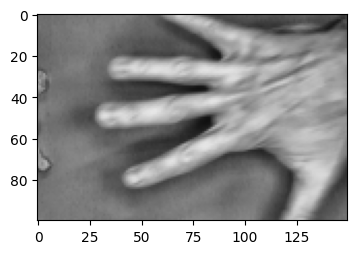

In [26]:
import cv2
errori_indice=[]
for i in range(len(real_label)):
    if real_label[i] != pred[i]:
        errori_indice.append(i)
file = test_gen.filepaths
errori = {"immagini":[], "LabelGiusta":[], "LabelPred":[]}
for i in errori_indice:
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(cv2.imread(file[i]), cv2.COLOR_BGR2RGB))
    print("Label predetta: {} Label vera: {}".format(keys[pred[i]], keys[real_label[i]]))

In [28]:
final_model.save("/home/ocelot/Desktop/secondo.keras")